# Volatility Surface

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import spicy as sp
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.optimize import fsolve
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

pd.set_option('display.max_rows', None)

We download the options data and the last value of underlying "symbol".

In [2]:
# Stock symbol of the underlying asset
symbol = "AAPL"

# Last value of the underlying asset
current_price = yf.Ticker(symbol).history(period='1d')['Close'].iloc[-1]

# Download of the available expiration dates
expiration_dates = yf.Ticker(symbol).options

options_data_list = []

for expiration_date in expiration_dates:
    options_full_data = yf.Ticker(symbol).option_chain(expiration_date)
    
    # call data
    calls = options_full_data.calls
    calls_mid_prices = calls[['strike']].assign(Mid_Price_Call=(calls['bid'] + calls['ask']) / 2)
    
    # put data
    puts = options_full_data.puts
    puts_mid_prices = puts[['strike']].assign(Mid_Price_Put=(puts['bid'] + puts['ask']) / 2)
    
    merged_data = pd.merge(calls_mid_prices, puts_mid_prices, on='strike', how='outer')
    
    # Remaining Days
    expiration_date = pd.to_datetime(expiration_date)
    remaining_days = float((expiration_date - datetime.today()).days)
    merged_data['Remaining Days'] = remaining_days
    options_data_list.append(merged_data)

options_df = pd.concat(options_data_list, ignore_index=True)

# Some conditions
options_df = options_df[options_df['Remaining Days'] <= 100]
options_df = options_df[(options_df['strike'] >= 0.8 * current_price) & (options_df['strike'] <= 1.2 * current_price)]

print(options_df)
print('current_price = ',current_price)

     strike  Mid_Price_Call  Mid_Price_Put  Remaining Days
26    140.0          31.100          0.020             5.0
27    145.0          26.000          0.030             5.0
28    150.0          21.225          0.050             5.0
29    152.5          18.600          0.060             5.0
30    155.0          16.200          0.075             5.0
31    157.5          13.575          0.100             5.0
32    160.0          11.150          0.145             5.0
33    162.5           8.675          0.225             5.0
34    165.0           6.000          0.415             5.0
35    167.5           4.350          0.860             5.0
36    170.0           2.690          1.685             5.0
37    172.5           1.495          3.015             5.0
38    175.0           0.745          4.925             5.0
39    177.5           0.375          6.850             5.0
40    180.0           0.195          9.450             5.0
41    182.5           0.115         11.750             5

We calculate the implied volatilities of calls and puts using the Newton-Raphson method.

In [3]:
def blackscholes(sigma, S, K, option_price, T, r, option_type='CALL'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'CALL':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2) - option_price
    elif option_type == 'PUT':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1) - option_price
    return price

S = current_price
r = 0.05 #arbitrary value
sigma0 = 0.6 #arbitrary value
implvol_calls = []
implvol_puts = []

for index, row in options_df.iterrows():
  K = row['strike']
  T = row['Remaining Days'] / 365
  
  # implied volatility for calls
  imp_vol_call = fsolve(blackscholes, sigma0, args=(S, K, row['Mid_Price_Call'], T, r, 'CALL'), xtol=1e-8, maxfev=500)
  implvol_calls.append(imp_vol_call[0])
  
  # implied volatility for puts
  imp_vol_put = fsolve(blackscholes, sigma0, args=(S, K, row['Mid_Price_Put'], T, r, 'PUT'), xtol=1e-8, maxfev=500)
  implvol_puts.append(imp_vol_put[0])

# Change into dataframe
implvol_df_calls = pd.DataFrame(implvol_calls, columns=['ImplVol Call'])
implvol_df_puts = pd.DataFrame(implvol_puts, columns=['ImplVol Put'])


selected_columns = ['strike', 'Remaining Days']
vol_surface_df = options_df[selected_columns].copy()
vol_surface_df['ImplVol Call'] = implvol_calls
vol_surface_df['ImplVol Put'] = implvol_puts

print(vol_surface_df)

C:\Users\hippo\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


     strike  Remaining Days  ImplVol Call  ImplVol Put
26    140.0             5.0      0.965750     0.664722
27    145.0             5.0      0.754141     0.585812
28    150.0             5.0      0.735339     0.510923
29    152.5             5.0      0.606417     0.466425
30    155.0             5.0      0.575762     0.423194
31    157.5             5.0      0.453729     0.382261
32    160.0             5.0      0.409325     0.344362
33    162.5             5.0      0.341323     0.307932
34    165.0             5.0      0.213874     0.282007
35    167.5             5.0      0.291559     0.269475
36    170.0             5.0      0.281879     0.261686
37    172.5             5.0      0.277656     0.260399
38    175.0             5.0      0.276761     0.281603
39    177.5             5.0      0.287613     0.241823
40    180.0             5.0      0.303279     0.338099
41    182.5             5.0      0.326222     0.320651
42    185.0             5.0      0.359888     0.309440
43    187.

Finally, we plot the volatility surface.

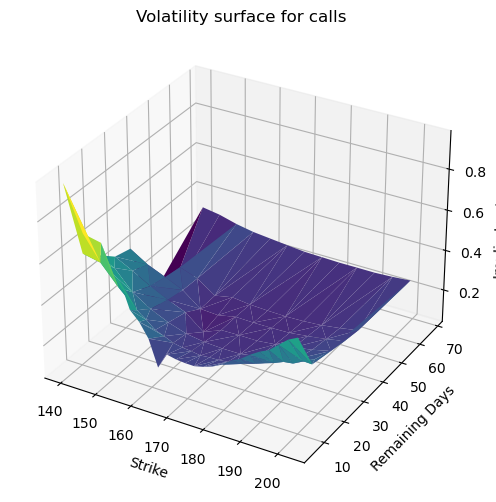

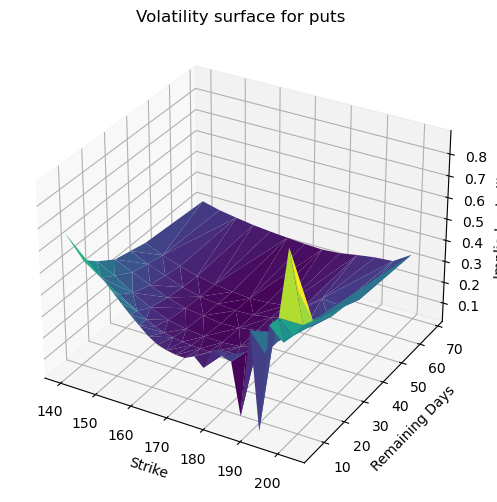

In [4]:
# Volatility surface for calls
fig_call = plt.figure(figsize=(10, 6))
ax_call = fig_call.add_subplot(111, projection='3d')

ax_call.plot_trisurf(vol_surface_df['strike'], vol_surface_df['Remaining Days'], vol_surface_df['ImplVol Call'], cmap='viridis')
ax_call.set_xlabel('Strike')
ax_call.set_ylabel('Remaining Days')
ax_call.set_zlabel('Implied volatility')
ax_call.set_title('Volatility surface for calls')
plt.show()

# # Volatility surface for puts
fig_put = plt.figure(figsize=(10, 6))
ax_put = fig_put.add_subplot(111, projection='3d')

ax_put.plot_trisurf(vol_surface_df['strike'], vol_surface_df['Remaining Days'], vol_surface_df['ImplVol Put'], cmap='viridis')
ax_put.set_xlabel('Strike')
ax_put.set_ylabel('Remaining Days')
ax_put.set_zlabel('Implied volatility')
ax_put.set_title('Volatility surface for puts')
plt.show()